In [1]:
from model.vision_transformer.dual_efficient_vit import DualEfficientViT
import torch
from torchsummary import summary

torch.manual_seed(0)
image = torch.randn((3, 3, 128, 128))
freq = torch.randn((3, 1, 128, 128))

model = DualEfficientViT(image_size=128, patch_size=1, version="cross_attention-freq-add", weight=0.5)

out = model(image, freq)
out

/home/aiotlab/anaconda3/envs/phucnp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


tensor([[0.3666],
        [0.3717],
        [0.3337]], grad_fn=<SigmoidBackward>)

In [59]:
import torch.nn as nn
import torch

class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, weights=None, eps=1e-7):
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.weights = weights      # [class_0, class_1]
        self.eps = eps
        
    def forward(self, pred, target):    # target: (batch_size, ), pred: (batch_size, )
        pred = pred.clamp(self.eps, 1-self.eps)
        if self.weights is not None:
            loss = self.weights[1] * (target * torch.log(pred)) + self.weights[0] * ((1- target) * torch.log(1-pred))
        else:
            loss = target * torch.log(pred) + (1 - target) * torch.log(1-pred)
        return torch.mean(torch.neg(loss))
    
# class_0, class_1 = 1, 4
# total = class_0 + class_1
# weights = [0.5 * total/class_0, 0.5 * total/class_1]
# wbce = WeightedBinaryCrossEntropy(weights=weights)

# print(weights)
# target = torch.tensor([0.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
# pred = torch.tensor([0.4, 0.6, 1.0, 1.0, 0.6])

# loss = wbce(target, pred)
# print(loss)

print("TEST")
bce = nn.BCELoss(reduction='none')
wbce = WeightedBinaryCrossEntropy(weights=[1,1])
pred = torch.rand((6))
tar = torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32)
print("target = ", tar )
print("pred = ", pred)
print(bce(pred, tar))
wbce(pred, tar)

TEST
target =  tensor([1., 0., 0., 0., 1., 0.])
pred =  tensor([0.3251, 0.0902, 0.3936, 0.6069, 0.1743, 0.4743])
tensor([1.1237, 0.0945, 0.5003, 0.9336, 1.7472, 0.6431])


tensor(0.8404)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weights=None, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.weights = weights      # [class_0, class_1] và class_0 + class_1 = 1
        self.gamma = gamma
        self.eps = eps
    
    def forward(self, pred, target):
        pred = pred.clamp(self.eps, 1 - self.eps)
        if self.weights is not None:
            loss = self.weights[1] * ((1 - pred) ** self.gamma) * target * torch.log(pred) + self.weights[0] * (pred ** self.gamma) * (1 - target) * torch.log(1 - pred)
        else:
            loss = ((1 - pred) * self.gamma) * target * torch.log(pred) + (pred ** self.gamma) * (1 - target) * torch.log(1 - pred)
        return torch.mean(torch.neg(loss))

print("Test loss")
torch.manual_seed(4)
# target = torch.tensor([0.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
# pred = torch.tensor([0.2, 0.8, 0.8, 0.8, 0.8])

batch = 4
pred = torch.rand((batch, ))
tar = torch.randint(0, 2, (batch, ))
num_0 = (tar > 0).to(torch.int32).sum().item()
num_1 = (tar == 0).to(torch.int32).sum(0).item()

print("Pred: ", pred)
print("Target: ", tar.shape)
print("Numner: ", num_0, num_1)
weights = [num_1 / (num_0 + num_1), num_0 / (num_0 + num_1)]
print(weights)

fl = FocalLoss(weights=weights, gamma=0.5)
fcloss = fl(pred, tar)

wbce = WeightedBinaryCrossEntropy(weights=weights)
wbceloss = wbce(pred, tar)

print("Focal loss: ", fcloss)
print("WBCE loss: ",wbceloss)


In [17]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


class DualEfficientViT(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,version="cross_attention-spatial-cat",weight=0.5):  
        super(DualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.spatial_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels)
                print("Extractor: ", extractor)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
            # for i in range(0, len(extractor._blocks)):
            #     for index, param in enumerate(extractor._blocks[i].parameters()):
            #         if i >= len(extractor._blocks) - 3:
            #             param.requires_grad = True
            #         else:
            #             param.requires_grad = False
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights


    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.freq_extractor.extract_features(frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_features))) + 1e-10)  # Hơi ảo???
        # print(ifreq_features.shape)
        # assert(ifreq_features.shape == freq_features.shape)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        ifreq_vectors = rearrange(ifreq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            # spatial_vectors = self.patch_to_embedding_1(spatial_vectors)
            # spatial_vectors += self.pos_embedding_1

            # freq_vectors = self.patch_to_embedding_2(freq_vectors)
            # freq_vectors += self.pos_embedding_2

            # ifreq_vectors = self.patch_to_embedding_2(ifreq_vectors)
            # ifreq_vectors += self.pos_embedding_2  
            # print("Step 2 shape: ", spatial_vectors.shape, freq_vectors.shape)  # (batchsize, num_patches, D)
            ##########
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

if __name__ == '__main__':
    x = torch.ones(32, 3, 256, 256)
    y = torch.ones(32, 1, 256, 256)
    model_ = DualEfficientViT(image_size=256, patch_size=2)
    out = model_(x, y)
    print(out.shape)
    from torchsummary import summary
    summary(model_, [(3, 256, 256), (1, 256, 256)], device="cpu")

Loaded pretrained weights for efficientnet-b0
Extractor:  EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_co

In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


class DualEfficientViTV2(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,version="cross_attention-spatial-cat",weight=0.5):  
        super(DualEfficientViTV2, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.spatial_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
            # for i in range(0, len(extractor._blocks)):
            #     for index, param in enumerate(extractor._blocks[i].parameters()):
            #         if i >= len(extractor._blocks) - 3:
            #             param.requires_grad = True
            #         else:
            #             param.requires_grad = False
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, freqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == freqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, freqs, freqs)
        return attn_outputs, attn_weights


    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.freq_extractor.extract_features(frequency_imgs)                     # shape (batchsize, 1280, 8, 8)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, freq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            out_attn = torch.bmm(attn_weights, freq_vectors)

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

if __name__ == '__main__':
    x = torch.ones(32, 3, 256, 256)
    y = torch.ones(32, 1, 256, 256)
    model_ = DualEfficientViTV2(image_size=256, patch_size=2)
    out = model_(x, y)
    print(out.shape)

In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


class DualCrossAttnEfficient(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,version="cross_attention-spatial-cat",weight=0.5,freeze=0):  
        super(DualCrossAttnEfficient, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.spatial_extractor = self.get_feature_extractor(freeze=freeze, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(freeze=freeze, num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()
        
        self.reduce_dim = nn.Linear(self.num_patches, 1)

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", freeze=0, pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            if freeze:
            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - 3:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights


    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.freq_extractor.extract_features(frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_features))) + 1e-10)  # Hơi ảo???
        # print(ifreq_features.shape)
        # assert(ifreq_features.shape == freq_features.shape)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        ifreq_vectors = rearrange(ifreq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            # spatial_vectors = self.patch_to_embedding_1(spatial_vectors)
            # spatial_vectors += self.pos_embedding_1

            # freq_vectors = self.patch_to_embedding_2(freq_vectors)
            # freq_vectors += self.pos_embedding_2

            # ifreq_vectors = self.patch_to_embedding_2(ifreq_vectors)
            # ifreq_vectors += self.pos_embedding_2  
            # print("Step 2 shape: ", spatial_vectors.shape, freq_vectors.shape)  # (batchsize, num_patches, D)
            ##########
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        print("Embed:", embed.shape)
        embed = embed.permute(0, 2, 1)
        x = self.reduce_dim(embed)
        print("Before squeeze:", x.shape)
        x = x.squeeze(-1)
        print("Before mlp:", x.shape)
        x = self.mlp_head(x)
        print("After mlp: ", x.shape)
        x = self.sigmoid(x)
        return x

if __name__ == '__main__':
    x = torch.ones(32, 3, 256, 256)
    y = torch.ones(32, 1, 256, 256)
    model_ = DualCrossAttnEfficient(image_size=256, patch_size=2)
    device = torch.device("cpu")
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

    model_.to(device)
    x, y = x.to(device), y.to(device)
    out = model_(x, y)
    print(out.shape)
    
    from torchsummary import summary
    summary(model_, [(3, 256, 256), (1, 256, 256)], device="cpu")

In [ ]:
from model.cnn.srm_2_stream_net.srm_2_stream import Two_Stream_Net
import torch

model = Two_Stream_Net(num_classes=1, pretrained="/mnt/disk1/phucnp/Graduation_Thesis/review/forensics/dl_technique/xception-b5690688.pth")
dummy = torch.rand((32,3,128,128))
out = model(dummy)
print(out.shape)

epoch
step


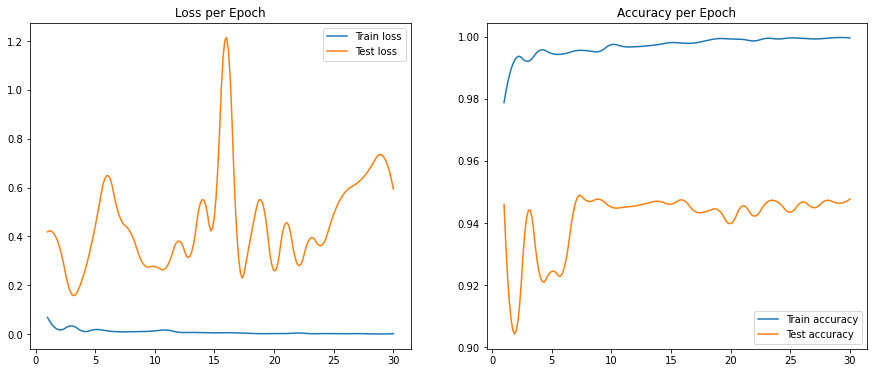

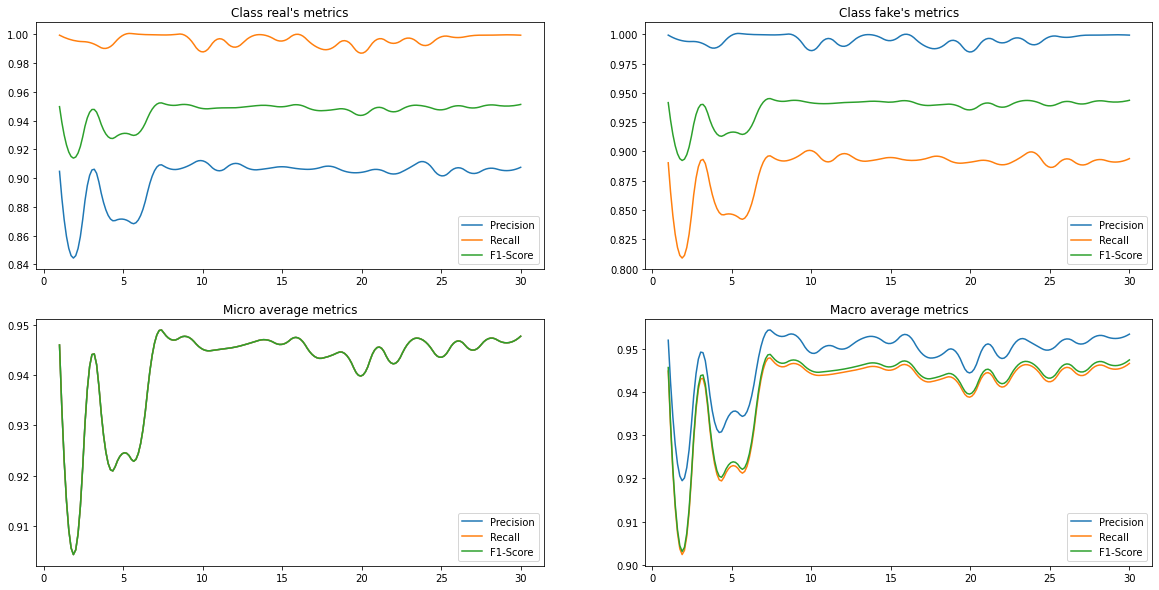

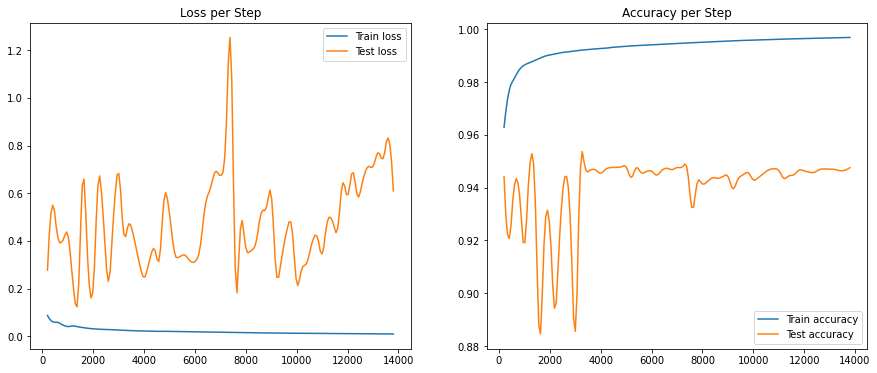

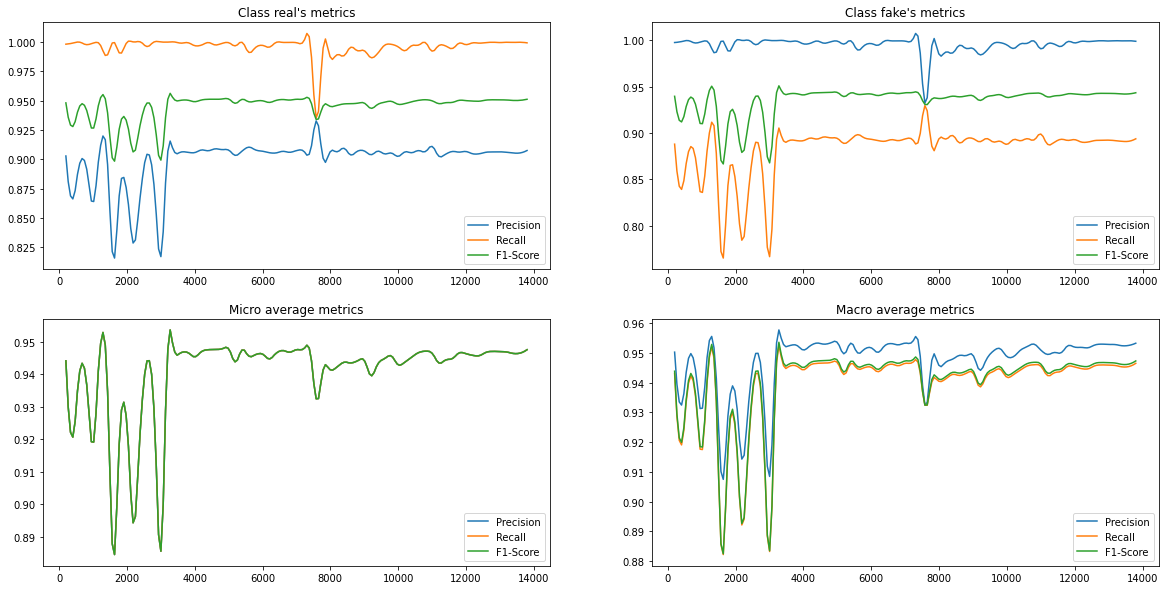

In [4]:
from plot_result import plot_graph

for iter_method in ['epoch', 'step']:
    print(iter_method)
    plot_graph("/mnt/disk1/phucnp/Graduation_Thesis/review/forensics/dl_technique/checkpoint/uadfv/dual_cross_attn/v_cross_attention-freq-add_w_0.8_lr_128_patch_0.0003_es_2_loss_none_freeze_bce/{}/result_test.csv".format(iter_method))